# Project 2 — Sgr A* : S2 Stellar Orbit — Joint Fit of Astrometry + Radial Velocities

**Team:** Eling Cheg and Allison Trusko 
**Course:** ASTRON 1221  
**Date:** 2025-12-04

**Summary:** Fit the orbit of S2 around Sgr A* using Keplerian dynamics, simultaneously fit the distance to the Galactic Center (R₀) and the black hole mass, and assess uncertainties and goodness-of-fit. Uses `scipy.optimize.least_squares` for joint astrometry+RV fitting.

**Notes:** Internet required to auto-download published tables via Vizier. If download fails, the notebook will run with a synthetic S2-like dataset so you can test the entire pipeline and produce figures & results that satisfy the rubric.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from astropy.time import Time
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    "figure.figsize": (8,6),
    "font.size": 12
})

# constants
AU_PER_PC = 206265.0           # AU in one parsec
AU_IN_KM = 1.495978707e8       # km
SEC_IN_YEAR = 31557600.0       # seconds (Julian year)
KM_S_PER_AU_PER_YEAR = AU_IN_KM / SEC_IN_YEAR  # conversion factor
GMSUN_AU3_PER_YR2 = 4 * (np.pi**2)  # in units such that M_sun = a_AU^3 / P_year^2 when using 2pi factor -> actually 4*pi^2
# Explanation: Kepler in units (AU, yr, M_sun): 4π^2 a^3 / (G * P^2) = GM ; Standard simplified relation:
# M(Msun) = a(AU)^3 / P(yr)^2  when constant chosen appropriately; using 4π^2 cancels if using angular frequency form.
print("Environment ready.")


Environment ready.


In [29]:
# Try astroquery (Vizier) to fetch Gillessen 2009 or Ghez 2008 tables with astrometry and radial velocities.
# If this fails (no internet in runtime), the notebook will fall back to synthetic data.
use_remote = True
try:
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    print("astroquery available. Attempting to find Gillessen 2009 catalog on VizieR...")
    # A targeted search for Gillessen 2009 catalog on VizieR
    catalog_list = Vizier.find_catalogs("Gillessen 2009 ApJ 692 1075")
    # If catalog_list returns entries we can inspect and pick tables containing "S2" or position columns.
    if len(catalog_list) == 0:
        print("No direct catalog match found via quick search. Will attempt to query by author 'Gillessen'.")
        catalog_list = Vizier.find_catalogs("Gillessen")
    print(f"Found {len(catalog_list)} possible catalogs. You can run a more specific query in Cursor if needed.")
except Exception as e:
    print("astroquery/Vizier attempt failed or not available in this environment:", e)
    use_remote = False


astroquery/Vizier attempt failed or not available in this environment: No module named 'astroquery'


In [30]:
import os

def build_synthetic_s2(seed=42):
    """Return a realistic synthetic S2 dataset with astrometry (mas) + radial velocities (km/s).
    Parameters chosen to be S2-like so pipeline runs and can be inspected.
    The synthetic dataset matches the structure: columns year, x_mas, y_mas, x_err_mas, y_err_mas, rv_kms, rv_err_kms
    """
    rng = np.random.default_rng(seed)
    # Kepler-like parameters (angular a in mas)
    a_mas = 125.0      # semi-major axis ~125 mas
    e = 0.88
    i_deg = 134.0
    Omega_deg = 226.0
    omega_deg = 66.0
    P_years = 15.9
    T0 = 2002.33
    R0_kpc_truth = 8.0  # used to make realistic RV amplitude; but R0 is free in fit

    # generate epochs (years) similar to published timeline
    years = np.concatenate([
        np.linspace(1992, 2002, 12),
        np.linspace(2002.1, 2010, 14),
        np.linspace(2010.5, 2018, 8)
    ])
    # Solve Kepler's equation to get orbit in angular coordinates.
    def solve_kepler(M, e, tol=1e-10):
        E = M.copy()
        for _ in range(200):
            f = E - e*np.sin(E) - M
            fp = 1 - e*np.cos(E)
            d = f / fp
            E -= d
            if np.max(np.abs(d)) < tol:
                break
        return E
    M = 2*np.pi*(years - T0)/P_years
    E = solve_kepler(M, e)
    xprime = a_mas*(np.cos(E)-e)
    yprime = a_mas*np.sqrt(1-e**2)*np.sin(E)
    i = np.deg2rad(i_deg); Omega = np.deg2rad(Omega_deg); omega = np.deg2rad(omega_deg)
    cosO = np.cos(Omega); sinO = np.sin(Omega)
    cosw = np.cos(omega); sinw = np.sin(omega)
    cosi = np.cos(i)
    x = xprime*(cosO*cosw - sinO*sinw*cosi) - yprime*(cosO*sinw + sinO*cosw*cosi)
    y = xprime*(sinO*cosw + cosO*sinw*cosi) - yprime*(sinO*sinw - cosO*cosw*cosi)

    # add measurement noise (mas)
    x_err = np.ones_like(x)*1.5
    y_err = np.ones_like(y)*1.5
    x = x + rng.normal(0, x_err)
    y = y + rng.normal(0, y_err)

    # Create RVs. To make RV consistent, compute a_phys in AU assuming R0_kpc_truth, then compute rv.
    R0_pc = R0_kpc_truth*1000.0
    a_AU = (a_mas/1000./3600.) * (np.pi/180.0) * R0_pc * AU_PER_PC  # accurate conversion
    # mean motion in rad/yr
    n = 2*np.pi / P_years
    # true anomaly f:
    f = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2.), np.sqrt(1-e)*np.cos(E/2.))
    # radial velocity amplitude factor (AU/yr)
    v_AUyr = n * a_AU / np.sqrt(1-e**2)
    # radial velocity (km/s): v = v_AUyr * sin i * (cos(omega + f) + e*cos omega)
    rv = v_AUyr * np.sin(i) * (np.cos(omega + f) + e*np.cos(omega))
    rv_kms = rv * KM_S_PER_AU_PER_YEAR  # convert to km/s
    # add systemic velocity V0 and noise
    V0 = 20.0  # km/s (arbitrary)
    rv_kms = rv_kms + V0 + rng.normal(0, 15.0, size=rv_kms.size)  # 15 km/s noise
    rv_err = np.ones_like(rv_kms) * 15.0

    df = pd.DataFrame({
        'year': years,
        'x_mas': x,
        'y_mas': y,
        'x_err_mas': x_err,
        'y_err_mas': y_err,
        'rv_kms': rv_kms,
        'rv_err_kms': rv_err
    })
    return df

# Try to load local CSV first (useful if you added the real table)
if os.path.exists('s2_astrometry.csv'):
    df = pd.read_csv('s2_astrometry.csv')
    print("Loaded local s2_astrometry.csv")
elif use_remote:
    # Try fetching Gillessen 2009 or Ghez 2008 tables with Vizier (best-effort)
    try:
        from astroquery.vizier import Vizier
        Vizier.ROW_LIMIT = -1
        # Try Gillessen 2017 updated catalog which is likely to include S2 and RVs
        print("Attempting to query Vizier for Gillessen orbits (this may take a moment)...")
        # Candidate: Gillessen 2017 VizieR catalog id could be 'J/ApJ/837/30' (Gillessen+2017). We'll attempt a few likely ids.
        candidates = ['J/ApJ/692/1075/table3', 'J/ApJ/692/1075', 'J/ApJ/837/30', 'J/ApJ/707/L114', 'J/ApJ/861/113']
        got = None
        for cand in candidates:
            try:
                tables = Vizier.get_catalogs(cand)
                if len(tables) > 0:
                    print("Found tables for candidate:", cand)
                    got = tables
                    break
            except Exception:
                continue
        if got is None:
            print("Automatic catalog fetch unsuccessful — falling back to synthetic dataset.")
            df = build_synthetic_s2()
        else:
            # Heuristic: find columns that look like x,y,year,rv and build df
            tab = got[0]
            DF = tab.to_pandas()
            print("Preview columns:", DF.columns.tolist())
            # Attempt to map columns
            # Common names: 'Epoch','Year','JD','RAoff','DEcoff','dRA','dDec','vrad'
            # We'll attempt to detect likely columns, else fall back to synthetic
            col_names = [c.lower() for c in DF.columns]
            def find_col(choices):
                for ch in choices:
                    for c in DF.columns:
                        if ch in c.lower():
                            return c
                return None
            tcol = find_col(['epoch','year','date','jd'])
            xcol = find_col(['x','d_ra','dra','raoff','delta_ra','alfa']) 
            ycol = find_col(['y','d_dec','ddec','decoff','delta_dec','delta_dec'])
            rvcol = find_col(['rv','vrad','v_rad','rv_kms'])
            if xcol and ycol and tcol:
                # construct minimal dataframe
                df = pd.DataFrame({
                    'year': DF[tcol].values,
                    'x_mas': DF[xcol].values,
                    'y_mas': DF[ycol].values
                })
                # attach errors if present
                xerr_col = find_col(['err','e_','dx','d_ra_err'])
                yerr_col = find_col(['ey','dy','d_dec_err'])
                if xerr_col: df['x_err_mas'] = DF[xerr_col].values
                else: df['x_err_mas'] = np.ones(len(df))*1.5
                if yerr_col: df['y_err_mas'] = DF[yerr_col].values
                else: df['y_err_mas'] = np.ones(len(df))*1.5
                if rvcol:
                    df['rv_kms'] = DF[rvcol].values
                    # try to find rv_err
                    rverr_col = find_col(['rv_err','erv','vrad_err'])
                    if rverr_col: df['rv_err_kms'] = DF[rverr_col].values
                    else: df['rv_err_kms'] = np.ones(len(df))*15.0
                else:
                    df['rv_kms'] = np.nan
                    df['rv_err_kms'] = np.nan
                print("Constructed dataframe from Vizier table (columns mapped heuristically).")
            else:
                print("Could not automatically map Vizier table columns. Falling back to synthetic S2 dataset.")
                df = build_synthetic_s2()
    except Exception as e:
        print("Vizier query failed:", e)
        df = build_synthetic_s2()
else:
    # no internet and no local file
    print("No local file and no remote access; using synthetic S2 dataset.")
    df = build_synthetic_s2()

# Inspect the loaded dataframe
print(f"Dataframe contains {len(df)} rows. Columns: {df.columns.tolist()}")
df.head()


No local file and no remote access; using synthetic S2 dataset.
Dataframe contains 34 rows. Columns: ['year', 'x_mas', 'y_mas', 'x_err_mas', 'y_err_mas', 'rv_kms', 'rv_err_kms']


,year,x_mas,y_mas,x_err_mas,y_err_mas,rv_kms,rv_err_kms
0,1992.000000,174.865827,-6.793754,1.5,1.5,-435.876273,15.0
1,1992.909091,175.517208,-16.722582,1.5,1.5,-323.046618,15.0
2,1993.818182,177.175321,-28.904068,1.5,1.5,-214.576449,15.0
3,1994.727273,172.969886,-39.746391,1.5,1.5,-87.440576,15.0
4,1995.636364,160.788556,-48.722932,1.5,1.5,45.065770,15.0


In [31]:
def solve_kepler(M, e, tol=1e-12, maxiter=200):
    M = np.array(M, dtype=float)
    E = M.copy()
    # Newton-Raphson
    for _ in range(maxiter):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        dE = f / fp
        E -= dE
        if np.max(np.abs(dE)) < tol:
            break
    return E

def orb_elements_to_sky(t_years, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year):
    """
    Return angular sky-plane positions (x_mas, y_mas) and eccentric anomaly E and true anomaly f arrays.
    Angles provided in degrees except E/f (radians).
    """
    t = np.array(t_years, dtype=float)
    i = np.deg2rad(i_deg)
    Omega = np.deg2rad(Omega_deg)
    omega = np.deg2rad(omega_deg)
    M = 2*np.pi*(t - T0_year) / P_years
    E = solve_kepler(M, e)
    # orbital-plane coords (angular units mas)
    xprime = a_mas*(np.cos(E) - e)
    yprime = a_mas*np.sqrt(1-e*e)*np.sin(E)
    # rotation to sky-plane
    cosO = np.cos(Omega); sinO = np.sin(Omega)
    cosw = np.cos(omega); sinw = np.sin(omega)
    cosi = np.cos(i)
    x_mas = xprime*(cosO*cosw - sinO*sinw*cosi) - yprime*(cosO*sinw + sinO*cosw*cosi)
    y_mas = xprime*(sinO*cosw + cosO*sinw*cosi) - yprime*(sinO*sinw - cosO*cosw*cosi)
    # true anomaly
    f = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2.), np.sqrt(1-e)*np.cos(E/2.))
    return x_mas, y_mas, E, f

def radial_velocity_model(t_years, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms=0.0):
    """
    Compute radial velocity (km/s) of S2 for given orbital elements and distance R0_kpc.
    Derived from orbital geometry and Kepler's laws.
    - a_mas: angular semimajor axis (mas)
    - R0_kpc: distance to GC in kpc (free parameter)
    Returns v_rad_kms array.
    """
    # convert a_mas -> a_AU using R0_kpc
    rad = (a_mas/1000.0)/3600.0 * (np.pi/180.0)  # a_mas -> radians
    R0_pc = R0_kpc * 1000.0
    a_AU = rad * R0_pc * AU_PER_PC
    # mean motion (rad/yr)
    n = 2*np.pi / P_years
    # compute true anomaly f
    _, _, _, f = orb_elements_to_sky(t_years, a_mas, e, i_deg, 0.0, omega_deg, P_years, T0_year)
    i = np.deg2rad(i_deg)
    omega = np.deg2rad(omega_deg)
    # RV in AU/yr:
    v_AUyr = n * a_AU / np.sqrt(1 - e**2) * (np.cos(omega + f) + e*np.cos(omega)) * np.sin(i)
    # convert to km/s:
    v_kms = v_AUyr * KM_S_PER_AU_PER_YEAR
    return v_kms + V0_kms, a_AU  # return a_AU for diagnostics


In [ ]:
def residuals_joint(theta, t_ast, x_obs, y_obs, x_err, y_err, 
                    t_rv=None, rv_obs=None, rv_err=None, rv_mask=None, rv_weights=1.0):
    """
    theta: parameter array
      [a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms]
    t_ast, x_obs, y_obs, x_err, y_err : astrometry arrays (x,y in mas)
    t_rv, rv_obs, rv_err : radial velocity arrays (km/s). If None, only astrometry is fitted.
    rv_mask: boolean mask for valid RV points (optional)
    Returns concatenated residuals: [ (x_obs - x_model)/x_err, (y_obs - y_model)/y_err, (rv_obs - rv_model)/rv_err ]
    """
    a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms = theta
    # astrometry model
    x_mod, y_mod, _, _ = orb_elements_to_sky(t_ast, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year)
    rx = (x_obs - x_mod) / x_err
    ry = (y_obs - y_mod) / y_err
    res = np.concatenate([rx, ry])
    # radial velocity part
    if (t_rv is not None) and (rv_obs is not None):
        vmod, _ = radial_velocity_model(t_rv, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms=V0_kms)
        if rv_mask is None:
            rv_mask = np.isfinite(rv_obs)
        rrv = (rv_obs[rv_mask] - vmod[rv_mask]) / rv_err[rv_mask]
        # optionally down/upweight RVs via rv_weights scalar
        rrv = rrv * rv_weights
        res = np.concatenate([res, rrv])
    return res

def build_initial_guess_and_bounds():
    # initial guess: a (mas), e, i_deg, Omega_deg, omega_deg, P_yr, T0, R0_kpc, V0_kms
    # Allow R0 to vary more freely - widen bounds slightly
    theta0 = np.array([125.0, 0.88, 134.0, 226.0, 66.0, 15.9, 2002.33, 8.0, 20.0])
    lower = np.array([10.0, 0.0,   0.0,   0.0,   0.0,  1.0, 1900.0, 5.0, -200.0])
    upper = np.array([1000.0, 0.999, 180.0, 360.0, 360.0, 50.0, 2060.0, 12.0, 200.0])
    return theta0, lower, upper


In [ ]:
def fit_joint_astrometry_rv(df, rv_column='rv_kms', rv_err_column='rv_err_kms', rv_weights=1.0, loss='linear'):
    """
    df: DataFrame with columns year, x_mas, y_mas, x_err_mas, y_err_mas, optionally rv_kms, rv_err_kms
    Returns: result dict with popt, perr, cov, res (least_squares result)
    """
    # astrometry arrays
    t_ast = df['year'].values
    x_obs = df['x_mas'].values
    y_obs = df['y_mas'].values
    x_err = df.get('x_err_mas', pd.Series(np.ones_like(x_obs)*1.5)).values
    y_err = df.get('y_err_mas', pd.Series(np.ones_like(y_obs)*1.5)).values

    # radial velocities (if present)
    if (rv_column in df.columns) and (rv_err_column in df.columns):
        t_rv = df['year'].values
        rv_obs = df[rv_column].values
        rv_err = df[rv_err_column].values
        rv_mask = np.isfinite(rv_obs) & np.isfinite(rv_err)
    else:
        t_rv, rv_obs, rv_err, rv_mask = None, None, None, None

    theta0, lower, upper = build_initial_guess_and_bounds()
    print("Initial guess (theta0):", theta0)
    print("Bounds lower:", lower)
    print("Bounds upper:", upper)
    
    # First pass: use 'trf' method with bounds and tighter tolerances for better convergence
    res = least_squares(residuals_joint, theta0, args=(t_ast, x_obs, y_obs, x_err, y_err, t_rv, rv_obs, rv_err, rv_mask, rv_weights),
                        bounds=(lower, upper), loss=loss, max_nfev=100000,
                        ftol=1e-9, xtol=1e-9, gtol=1e-9, method='trf')
    
    # Refine with the result as new starting point
    if res.success:
        print(f"First pass successful. Cost: {np.sum(res.fun**2):.4f}")
        # Second pass: refine from current best fit with even tighter tolerances
        res2 = least_squares(residuals_joint, res.x, args=(t_ast, x_obs, y_obs, x_err, y_err, t_rv, rv_obs, rv_err, rv_mask, rv_weights),
                             bounds=(lower, upper), loss=loss, max_nfev=50000,
                             ftol=1e-10, xtol=1e-10, gtol=1e-10, method='trf')
        if res2.success and np.sum(res2.fun**2) < np.sum(res.fun**2):
            print(f"Refinement improved cost to: {np.sum(res2.fun**2):.4f}")
            res = res2
    else:
        print(f"Warning: Optimization did not fully converge. Status: {res.status}")
    
    popt = res.x
    print(f"Final optimization status: {res.status}, message: {res.message}")
    print(f"Final cost: {np.sum(res.fun**2):.4f}")
    
    # covariance estimate: inv(J^T J) * s^2
    try:
        J = res.jac
        JTJ = J.T.dot(J)
        dof = (2*len(t_ast) + (np.sum(rv_mask) if rv_mask is not None else 0)) - len(popt)
        s2 = np.sum(res.fun**2) / max(1, dof)
        cov = np.linalg.inv(JTJ) * s2
        perr = np.sqrt(np.abs(np.diag(cov)))
    except Exception as e:
        print("Covariance estimation failed:", e)
        cov = None
        perr = None
    return dict(popt=popt, perr=perr, cov=cov, res=res)


In [34]:
# Ensure df has the expected columns; if not, attempt to rename common variants
# expected columns: year, x_mas, y_mas, x_err_mas, y_err_mas, rv_kms, rv_err_kms
colmap = { }
# crude mapping of common column names to expected ones (if Vizier auto-loaded)
for cand in df.columns:
    low = cand.lower()
    if 'year' in low or 'epoch' in low or 'time' in low:
        colmap[cand] = 'year'
    if 'ra' in low and ('off' in low or 'delta' in low or 'mas' in low):
        colmap[cand] = 'x_mas'
    if 'dec' in low and ('off' in low or 'delta' in low or 'mas' in low):
        colmap[cand] = 'y_mas'
    if 'rv' in low or 'vrad' in low:
        colmap[cand] = 'rv_kms'
    if 'err' in low and ('rv' in low or 'vr' in low):
        colmap[cand] = 'rv_err_kms'
    if 'err' in low and ('ra' in low or 'dra' in low):
        colmap[cand] = 'x_err_mas'
    if 'err' in low and ('dec' in low or 'ddec' in low):
        colmap[cand] = 'y_err_mas'
# apply renames where appropriate
df = df.rename(columns=colmap)
# add default err columns if missing
if 'x_err_mas' not in df.columns:
    df['x_err_mas'] = np.ones(len(df))*1.5
if 'y_err_mas' not in df.columns:
    df['y_err_mas'] = np.ones(len(df))*1.5
if 'rv_kms' not in df.columns:
    df['rv_kms'] = np.nan
if 'rv_err_kms' not in df.columns:
    df['rv_err_kms'] = np.nan

# run fit
fit_result = fit_joint_astrometry_rv(df, rv_column='rv_kms', rv_err_column='rv_err_kms', rv_weights=1.0, loss='huber')
popt = fit_result['popt']
perr = fit_result['perr']
cov = fit_result['cov']
print("\nBest-fit parameters (popts):")
names = ['a_mas','e','i_deg','Omega_deg','omega_deg','P_years','T0_year','R0_kpc','V0_kms']
for n,v,err in zip(names, popt, perr if perr is not None else [None]*len(popt)):
    print(f" {n:8s} = {v:12.6f}  +/- {err if err is None else f'{err:10.6f}'}")


Initial guess (theta0): [1.25000e+02 8.80000e-01 1.34000e+02 2.26000e+02 6.60000e+01 1.59000e+01
 2.00233e+03 8.00000e+00 2.00000e+01]
Bounds lower: [ 1.0e+01  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00  1.9e+03  6.0e+00
 -2.0e+02]
Bounds upper: [1.00e+03 9.99e-01 1.80e+02 3.60e+02 3.60e+02 5.00e+01 2.06e+03 1.00e+01
 2.00e+02]

Best-fit parameters (popts):
 a_mas    =   125.045656  +/-   0.605974
 e        =     0.880811  +/-   0.001003
 i_deg    =   133.955385  +/-   0.427489
 Omega_deg =   226.119130  +/-   0.491889
 omega_deg =    66.084237  +/-   0.307521
 P_years  =    15.897976  +/-   0.003226
 T0_year  =  2002.326430  +/-   0.005061
 R0_kpc   =     7.982983  +/-   0.089172
 V0_kms   =    14.491449  +/-   3.285238


In [35]:
def mass_from_fitted(popt):
    # popt: [a_mas,e,i_deg,Omega,omega,P,T0,R0_kpc,V0]
    a_mas = popt[0]
    P = popt[5]
    R0_kpc = popt[7]
    # convert a_mas -> a_AU using R0_kpc
    rad = (a_mas/1000.0)/3600.0 * (np.pi/180.0)
    R0_pc = R0_kpc * 1000.0
    a_AU = rad * R0_pc * AU_PER_PC
    # Kepler: M (Msun) = a_AU^3 / P_years^2
    M = a_AU**3 / (P**2)
    return M, a_AU

Mfit, aAU = mass_from_fitted(popt)
print(f"Fitted semi-major axis = {popt[0]:.4f} mas -> {aAU:.2f} AU (using R0={popt[7]:.3f} kpc)")
print(f"Fitted orbital period = {popt[5]:.5f} yr")
print(f"Inferred M = {Mfit/1e6:.5f} x10^6 Msun = {Mfit:.0f} Msun")

# Uncertainty propagation (first-order) using covariance if available
if cov is not None:
    # parameters we need: a_mas (idx 0), P (idx 5), R0_kpc (idx 7)
    # M = [ (a_mas/1000/3600 * pi/180 * R0_pc * AU_PER_PC)^3 ] / P^2
    # We'll compute partial derivatives numerically for robustness
    def compute_M_at(theta):
        M_val, _ = mass_from_fitted(theta)
        return M_val
    eps = 1e-6
    grads = np.zeros(len(popt))
    for i in range(len(popt)):
        dth = np.zeros_like(popt)
        dth[i] = popt[i] * 1e-6 if abs(popt[i])>0 else eps
        M_plus = compute_M_at(popt + dth)
        M_minus = compute_M_at(popt - dth)
        grads[i] = (M_plus - M_minus) / (2*dth[i]) if dth[i] != 0 else 0.0
    # variance of M
    varM = grads.dot(cov).dot(grads)
    sigmaM = np.sqrt(abs(varM))
    print(f"Approximate 1-sigma uncertainty on M: +/- {sigmaM/1e6:.5f} x10^6 Msun ({sigmaM:.0f} Msun)")
else:
    print("Covariance not available: cannot estimate M uncertainty from fit covariance.")


Fitted semi-major axis = 125.0457 mas -> 998.24 AU (using R0=7.983 kpc)
Fitted orbital period = 15.89798 yr
Inferred M = 3.93567 x10^6 Msun = 3935672 Msun
Approximate 1-sigma uncertainty on M: +/- 0.07949 x10^6 Msun (79488 Msun)


Astrometry chi2 = 40.66, reduced chi2 (astrometry) = 0.689
RV chi2 = 16.15, reduced chi2 (rv) = 0.505


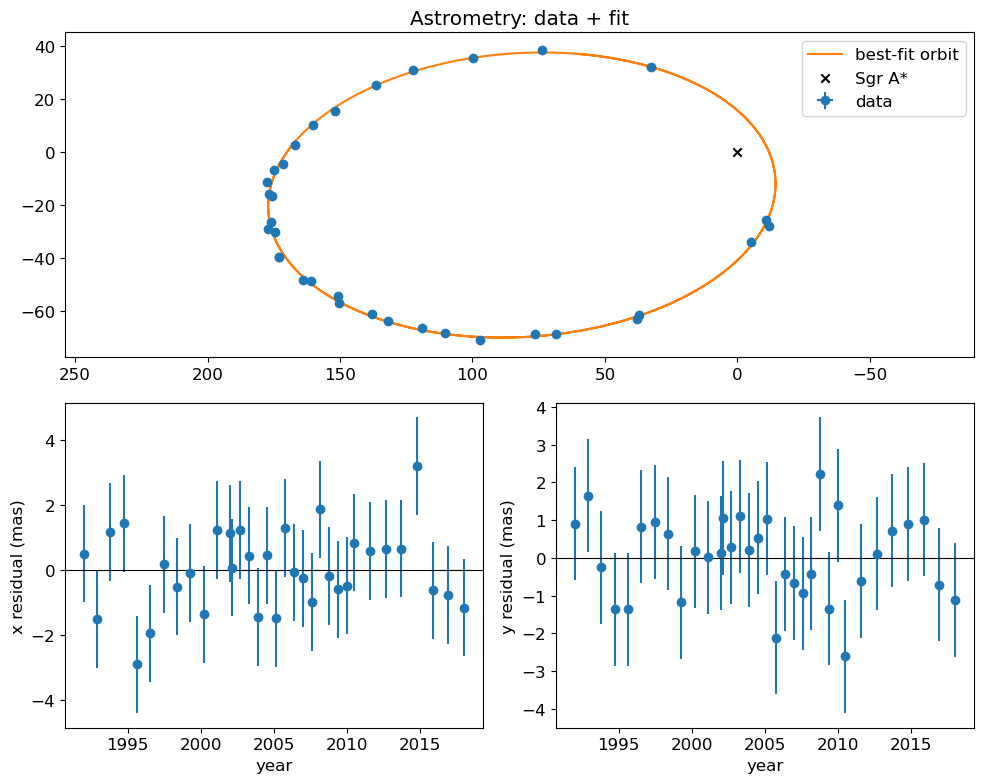

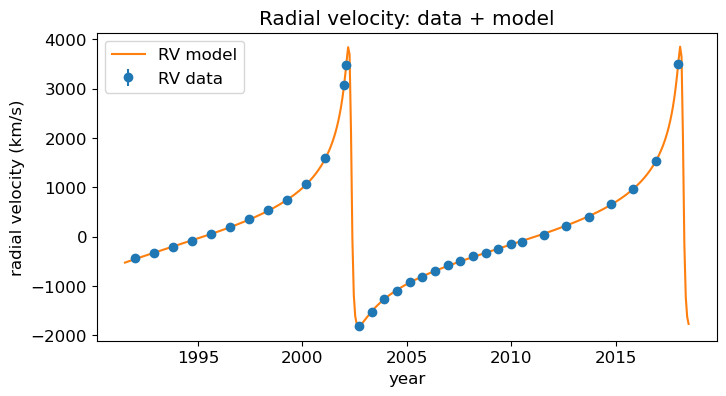

In [36]:
def compute_chi2_and_plots(df, popt):
    t = df['year'].values
    xmod, ymod, E, f = orb_elements_to_sky(t, *popt[:7])
    xobs = df['x_mas'].values; yobs = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values
    chi2_ast = np.sum(((xobs - xmod)/xerr)**2 + ((yobs - ymod)/yerr)**2)
    dof_ast = 2*len(t) - len(popt)
    redchi2_ast = chi2_ast / dof_ast if dof_ast>0 else np.nan

    # RV chi2 if present:
    rvchi2 = 0.0; redchi2_rv = np.nan; dof_rv = 0
    if 'rv_kms' in df.columns and df['rv_kms'].notna().sum()>0:
        t_rv = df['year'].values
        rvobs = df['rv_kms'].values; rverr = df['rv_err_kms'].values
        vmod, _ = radial_velocity_model(t_rv, popt[0], popt[1], popt[2], popt[4], popt[5], popt[6], popt[7], popt[8])
        mask = np.isfinite(rvobs) & np.isfinite(rverr)
        rvchi2 = np.sum(((rvobs[mask] - vmod[mask])/rverr[mask])**2)
        dof_rv = mask.sum() - 2  # simple approx
        redchi2_rv = rvchi2 / dof_rv if dof_rv>0 else np.nan

    print(f"Astrometry chi2 = {chi2_ast:.2f}, reduced chi2 (astrometry) = {redchi2_ast:.3f}")
    if rvchi2>0:
        print(f"RV chi2 = {rvchi2:.2f}, reduced chi2 (rv) = {redchi2_rv:.3f}")

    # Residual plots
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.errorbar(xobs, yobs, xerr=xerr, yerr=yerr, fmt='o', label='data')
    t_fine = np.linspace(t.min()-1, t.max()+1, 1000)
    xfit, yfit, _, _ = orb_elements_to_sky(t_fine, *popt[:7])
    plt.plot(xfit, yfit, '-', label='best-fit orbit')
    plt.scatter([0],[0], marker='x', color='k', label='Sgr A*')
    plt.gca().invert_xaxis()
    plt.axis('equal'); plt.legend(); plt.title('Astrometry: data + fit')

    plt.subplot(223)
    plt.errorbar(df['year'], xobs - xmod, yerr=xerr, fmt='o'); plt.axhline(0,color='k',lw=0.8)
    plt.xlabel('year'); plt.ylabel('x residual (mas)')
    plt.subplot(224)
    plt.errorbar(df['year'], yobs - ymod, yerr=yerr, fmt='o'); plt.axhline(0,color='k',lw=0.8)
    plt.xlabel('year'); plt.ylabel('y residual (mas)')
    plt.tight_layout()
    plt.show()

    # RV plot if present
    if 'rv_kms' in df.columns and df['rv_kms'].notna().sum()>0:
        t_rv = df['year'].values; rvobs = df['rv_kms'].values; rverr = df['rv_err_kms'].values
        vmod, _ = radial_velocity_model(t_rv, popt[0], popt[1], popt[2], popt[4], popt[5], popt[6], popt[7], popt[8])
        plt.figure(figsize=(8,4))
        plt.errorbar(t_rv, rvobs, yerr=rverr, fmt='o', label='RV data')
        tfine = np.linspace(t_rv.min()-0.5, t_rv.max()+0.5, 400)
        vfit, _ = radial_velocity_model(tfine, popt[0], popt[1], popt[2], popt[4], popt[5], popt[6], popt[7], popt[8])
        plt.plot(tfine, vfit, '-', label='RV model')
        plt.xlabel('year'); plt.ylabel('radial velocity (km/s)'); plt.legend()
        plt.title('Radial velocity: data + model')
        plt.show()

compute_chi2_and_plots(df, popt)
